# Demonstration:  Bayesian Coin Tossing

## Bayesian updating

$  \newcommand{\thetavec}{\boldsymbol{\theta}} \newcommand{\pr}{\textrm{p}}$
Recall Bayes' theorem with $\thetavec$ the vector of parameters we seek and information $I$ is kept implicit.

$$
  \overbrace{\pr(\thetavec \mid \textrm{data},I)}^{\textrm{posterior}} =
  \frac{\color{red}{\overbrace{\pr(\textrm{data} \mid \thetavec,I)}^{\textrm{likelihood}}} \times
   \color{blue}{\overbrace{\pr(\thetavec \mid I)}^{\textrm{prior}}}}
   {\color{darkgreen}{\underbrace{\pr(\textrm{data} \mid I)}_{\textrm{evidence}}}}
$$

If we view the prior as the initial information we have about $\thetavec$, summarized as a probability density function, then Bayes' theorem tells us how to <em>update</em> that information after observing some data: this is the posterior pdf.  Here we will give some examples of how this plays out when tossing coins.


### Determining the bias of a coin

The idea here is that we are observing successive flips of a coin, which is a proxy for any process that has a binary outcome.  There is a definite true probability for getting heads, which we'll label $p_h$, but we don't know what it is.  We start with a preconceived notion of the probability expressed in terms of a prior pdf for $p_h$, i.e., $\pr(p_h)$.  With each flip of the coin, we have more information, so our goal is to <em>update</em> our expectation of $p_h$, meaning we want the posterior $p(p_h \vert \mbox{\# tosses, \# heads})$. 

Let us perform a computer simulation of a coin-tossing experiment. This provides the data that we will be analysing.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
rng = np.random.default_rng(seed=999)         # for reproducibility
pHtrue=0.6                       # biased coin
flips=rng.random(2**12) # simulates 4096 coin flips
heads=flips<pHtrue              # boolean array, heads[i]=True if flip i is heads

In the light of this data, our inference about the fairness of this coin is summarized by the conditional pdf: $p(p_H|D,I)$. This is, of course, shorthand for the limiting case of a continuum of propositions for the value of $p_H$; that is to say, the probability that $p_H$ lies in an infinitesimally narrow range is given by $p(p_H|D,I) dp_H$. 

Please see the previous chapter on the assignment of a prior and the likelihood. Here, we perform the setup of this Bayesian framework on the computer. 

In [7]:
def prior(pH):
    "returns an array of prior probability densities"
    p=np.zeros_like(pH)
    p[(0<=pH)&(pH<=1)]=1      # allowed range: 0<=pH<=1
    return p                # uniform prior
def likelihood(pH,data):
    "returns an array of likelihood probability densities"
    N = len(data)
    no_of_heads = sum(data)
    no_of_tails = N - no_of_heads
    return pH**no_of_heads * (1-pH)**no_of_tails
def posterior(pH,data):
    "returns an array of (normalized) posterior probability densities"
    p=prior(pH)*likelihood(pH,data)
    norm=np.trapz(p,pH)
    return p/norm

The next step is to confront this setup with the simulated data. To get a feel for the result, it is instructive to see how the posterior pdf evolves as we obtain more and more data pertaining to the coin.

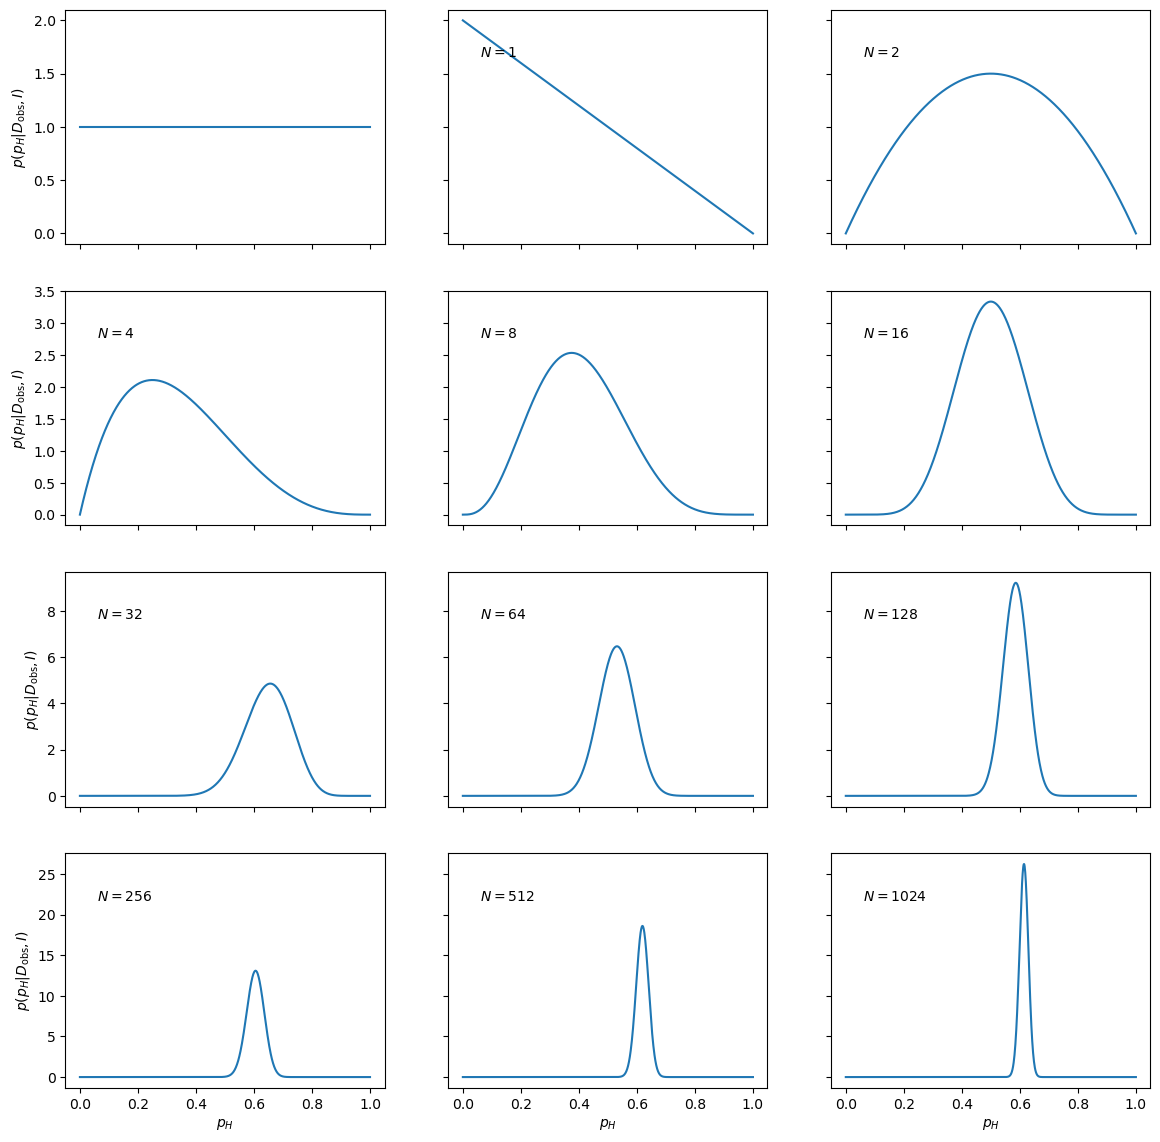

In [8]:
pH=np.linspace(0,1,1000)
fig, axs = plt.subplots(nrows=4,ncols=3,sharex=True,sharey='row',figsize=(14,14))
axs_vec=np.reshape(axs,-1)
axs_vec[0].plot(pH,prior(pH))
for ndouble in range(11):
    ax=axs_vec[1+ndouble]
    ax.plot(pH,posterior(pH,heads[:2**ndouble]))
    ax.text(0.1, 0.8, '$N={0}$'.format(2**ndouble), transform=ax.transAxes)
for row in range(4): axs[row,0].set_ylabel('$p(p_H|D_\mathrm{obs},I)$')
for col in range(3): axs[-1,col].set_xlabel('$p_H$')

Please, feel free to play with this setup yourself by modifying the code above. Things to explore:
* The choice of `pH`.
* The number of data.
* The choice of prior (i.e. the function `prior`).
* Is there a difference between the results obtained for many sequential updates (i.e. updating the posterior after each toss), and a single update with all data? Can you show this result analytically?

## Degree of belief intervals

Now we are going to compute some Bayesian confidence intervals, aka DoB intervals, aka credibility intervals....
You shoud go through this section once using the numbers provided, and then come back and run it again. You can also employ priors other than those provided if you wish.

In [10]:
import scipy.stats as stats

In [11]:
def dist_stuff(dist):
    """
    Finds the median, mean, and 68%/95% credible intervals for the given 
    1-d distribution (which is an object from scipy.stats).  
    """
    # For x = median, mean: return x and the value of the pdf at x as a list
    median = [dist.median(), dist.pdf(dist.median())]  
    mean = [dist.mean(), dist.pdf(dist.mean())]
    # The left and right limits of the credibility interval are returned
    cred68 = dist.interval(0.68)
    cred95 = dist.interval(0.95)
    return median, mean, cred68, cred95

In [12]:
def dist_mode(dist, x):
    """
    Return the mode (maximum) of the 1-d distribution for array x.
    """
    x_max_index = dist.pdf(x).argmax()
    # Return x of the maximum and the value of the pdf at that x 
    mode = [x[x_max_index], dist.pdf(x[x_max_index])]
    return mode

Then we use this to write an object that will give us back the mean, 68%, and 95% intervals for a uniform prior. 

In [13]:
def print_uniform_prior_measures(N,heads):
    """
    Prints out the mean, and 68 and 95 CIs for a uniform prior. Note that this means alpha=beta=1.
    """
    x = np.linspace(0, 1, 301)   # mesh for posterior plots (enough so smooth)
    median, mean, cred68, cred95 = dist_stuff(stats.beta(1+heads,1+N-heads))
    mode=dist_mode(stats.beta(1+heads,1+N-heads),x)
    print(f'For a uniform prior, and {heads} heads out of {N} tosses:')
    print(f'  mean={mean[0]:.3f}; Mode={mode[0]:.3f}')
    print(f'  68% DoB interval=[{cred68[0]:.3f},{cred68[1]:.3f}]')
    print(f'  95% DoB interval=[{cred95[0]:.3f},{cred95[1]:.3f}]')
    return                              

Now we fill in the values for N and heads from running the widget. 

In [15]:
num_coin_tosses=10
print_uniform_prior_measures(num_coin_tosses,np.sum(heads[:num_coin_tosses]))

For a uniform prior, and 4 heads out of 10 tosses:
  mean=0.417; Mode=0.400
  68% DoB interval=[0.276,0.558]
  95% DoB interval=[0.167,0.692]


In [16]:
print('The actual value of p_H is',pHtrue)

The actual value of p_H is 0.6


So, at least for the data I generated, the 68% DoB for a uniform prior does not contain the true value. Should you be surprised? 

In [19]:
def print_frequentist_estimators(N,heads):
    """
    Finds the mean, and 68 and 95 CIs. Note that this means alpha_1=beta_1=1.
    """
    mean=heads/N
    sigma=np.sqrt(mean*(1-mean)/N)
    print(f'For {heads} heads out of {N} tosses, the frequentist 68% confidence interval=',\
          f'({mean-sigma:.3f},{mean+sigma:.3f})')
    return

In [20]:
print_frequentist_estimators(num_coin_tosses,np.sum(heads[:num_coin_tosses]))

For 4 heads out of 10 tosses, the frequentist 68% confidence interval= (0.245,0.555)


Which Bayesian estimator is the frequentist mean closest to?

Is the frequentist 68% confidence interval the same as the Bayesian 68% DoB interval? If so, should they be? If not, why are they different?

Now we will also generate the summary statistics for the other priors. (What is coded is for the default values. After running through the exercise you can come back and try and change it; indeed, you should do that if you comparing to results where you altered the prior above.)

In [21]:
def print_likely_fair_prior_measures(N,heads):
    """
    Prints out the mean, and 68 and 95 CIs for the "coin is likely fair" prior. This means alpha=beta=30.
    """
    x = np.linspace(0, 1, 301)   # mesh for posterior plots (enough so smooth)
    median, mean, cred68, cred95 = dist_stuff(stats.beta(30+heads,30+N-heads))
    mode=dist_mode(stats.beta(1+heads,1+N-heads),x)
    print('For the trusting-person`s prior, and',heads,'heads out of',N,'tosses:')
    print (f'Mean={mean[0]:.3f}; Mode={mode[0]:.3f}')
    print (f'68% DoB interval=[{cred68[0]:.3f},{cred68[1]:.3f}]')
    print (f'95% DoB interval=[{cred95[0]:.3f},{cred95[1]:.3f}]')
    return              

In [22]:
print_likely_fair_prior_measures(num_coin_tosses,np.sum(heads[:num_coin_tosses]))

For the trusting-person`s prior, and 4 heads out of 10 tosses:
Mean=0.486; Mode=0.400
68% DoB interval=[0.426,0.545]
95% DoB interval=[0.370,0.602]


In [23]:
def print_likely_unfair_prior_measures(N,heads):
    """
    Prints out the mean, and 68 and 95 CIs for the "coin is likely unfair" prior. This means alpha=beta=0.2.
    """
    x = np.linspace(0, 1, 301)   # mesh for posterior plots (enough so smooth)
    median, mean, cred68, cred95 = dist_stuff(stats.beta(0.2+heads,0.2+N-heads))
    mode=dist_mode(stats.beta(1+heads,1+N-heads),x)
    print('For the nasty-suspicious-mind prior, and',heads,'heads out of',N,'tosses:')
    print (f'Mean={mean[0]:.3f}; Mode={mode[0]:.3f}')
    print (f'68% DoB interval=[{cred68[0]:.3f},{cred68[1]:.3f}]')
    print (f'95% DoB interval=[{cred95[0]:.3f},{cred95[1]:.3f}]')
    return              

In [24]:
print_likely_unfair_prior_measures(num_coin_tosses,np.sum(heads[:num_coin_tosses]))

For the nasty-suspicious-mind prior, and 4 heads out of 10 tosses:
Mean=0.404; Mode=0.400
68% DoB interval=[0.253,0.555]
95% DoB interval=[0.144,0.699]


So what is the best approach in this case? Objectivity? Trust? Suspicion?

Now having printed out the results for my particular coin-tossing experiment you should play with things and see what the different summary statistics give for other "experimental runs".

Don't forget to change the seed for the random number generator, otherwise you will get exactly the same sequence of coin tosses.